# Master MVA- Generative Modeling
### Assignment 25th Feb
### Benjamin Deporte

### Import librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Set Up

In [2]:
torch.cuda.is_available()

True

In [4]:
torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(f"Using {device}")

!nvidia-smi # if using RTX at IRT

# set seeds for reproductibility
random_seed = 42
rng = np.random.default_rng(seed=random_seed)
torch.manual_seed(random_seed)

Using cuda
Mon Feb 17 15:46:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8             17W /  370W |      26MiB /  10240MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------------

# 2D-Data

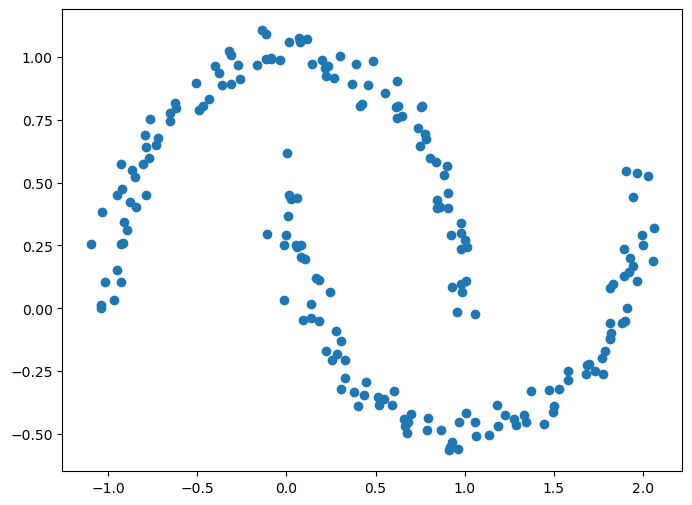

In [5]:
# Soyons fous... nous utiliserons 2-moons ici

from sklearn.datasets import make_moons

# paramètres
N_SAMPLES = 200
NOISE = 0.05

# génération données
X, _ = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=random_seed)

# force dans [0,1]^2
# X[:,0] = (X[:,0] - np.min(X[:,0])) / (np.max(X[:,0]) - np.min(X[:,0]))
# X[:,1] = (X[:,1] - np.min(X[:,1])) / (np.max(X[:,1]) - np.min(X[:,1]))

# formate en tensor
X_data = torch.tensor(X).to(device)

# plot dataset
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_data.detach().cpu().numpy()[:,0], X_data.detach().cpu().numpy()[:,1])

plt.show()

# GAN Training

In [6]:
# Generator - on ré-utilise le code du TP

class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=device):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        # create nlayers of nn.Linear of size
        # - n_in for the first one
        # - n_hid for the others
        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        # otuput layer, n_out neurons then Sigmoid
        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            # nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

In [ ]:
n_in = 10    # input dimension, dimension de la Gaussienne dont est tiré z
d = 2        # dimension des data points
b = 100      # batch size

# Initialise générateur
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)
z = torch.randn(b, n_in, device=device)
X_gen = G(z).detach().cpu().numpy()

In [8]:
def display(x_data=X_data, x_gen=None):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
    ax.scatter(x_data[:,0], x_data[:,1], c='navy')
    plt.show()

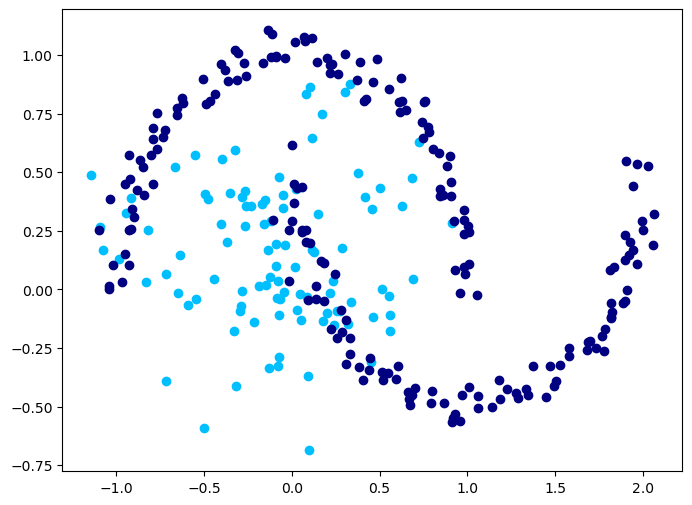

In [9]:
# Teste le sampling
display(X_data.cpu(), X_gen)

In [10]:
# Discriminator - code TP

class DiscriminatorGAN(nn.Module):
  def __init__(self, n_in=2, n_hid=10, device=device):
    super(DiscriminatorGAN, self).__init__()

    # n_in is the input dimension, 2 here as data points are 2D
    self.n_hid = n_hid
    self.n_in = n_in    

    self.fc1 = nn.Linear(n_in, n_hid).to(device)
    self.fc2 = nn.Linear(n_hid, n_hid).to(device)
    self.fc3 = nn.Linear(n_hid, 1).to(device)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    # proba que x soit issu de p_data et non pas p_gen = G(p_z)
    y = nn.Sigmoid()(self.fc3(y))
    return y

### GAN Training Loop

TP code Evolution :
- commented code regarding gradient clipping
- added kwarg "GenFreeze" to allow training of Discriminator only
- a couple of prints

In [11]:
def train_GAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  n_epochs=50,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10
  ):
  
  # Report out
  print(f"Training GAN - GenFreeze={GenFreeze}")
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []

  # reporting 
  iter_display = iter_display

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()
        # GAN : no gradient cliping !
        # for p in D.parameters():
        #     p.data.clamp_(-clip_value, clip_value)

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data.cpu()[:,0], X_data.cpu()[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### Training D, fixed G

Ok, we succeed in training D (sort of : -.80 loss vs -1.00 optimal) when G is frozen.

Training GAN - GenFreeze=True
[1/200] 	Loss_D: -0.5877	Loss_G: -0.0551
[2/200] 	Loss_D: -0.6245	Loss_G: -0.0383
[3/200] 	Loss_D: -0.6301	Loss_G: -0.0393
[4/200] 	Loss_D: -0.6384	Loss_G: -0.0619
[5/200] 	Loss_D: -0.6557	Loss_G: -0.1021
[6/200] 	Loss_D: -0.6929	Loss_G: -0.0544
[7/200] 	Loss_D: -0.7371	Loss_G: -0.0401
[8/200] 	Loss_D: -0.7734	Loss_G: -0.0869
[9/200] 	Loss_D: -0.7126	Loss_G: -0.0490
[10/200] 	Loss_D: -0.7335	Loss_G: -0.1019
[11/200] 	Loss_D: -0.7804	Loss_G: -0.0661
[12/200] 	Loss_D: -0.7583	Loss_G: -0.0303
[13/200] 	Loss_D: -0.7635	Loss_G: -0.0488
[14/200] 	Loss_D: -0.7792	Loss_G: -0.0539
[15/200] 	Loss_D: -0.7995	Loss_G: -0.0779
[16/200] 	Loss_D: -0.7265	Loss_G: -0.0871
[17/200] 	Loss_D: -0.7669	Loss_G: -0.0611
[18/200] 	Loss_D: -0.7766	Loss_G: -0.0796
[19/200] 	Loss_D: -0.7629	Loss_G: -0.0760
[20/200] 	Loss_D: -0.7809	Loss_G: -0.0311
[21/200] 	Loss_D: -0.7689	Loss_G: -0.0804
[22/200] 	Loss_D: -0.7900	Loss_G: -0.0397
[23/200] 	Loss_D: -0.7919	Loss_G: -0.0918
[24/200] 	Los

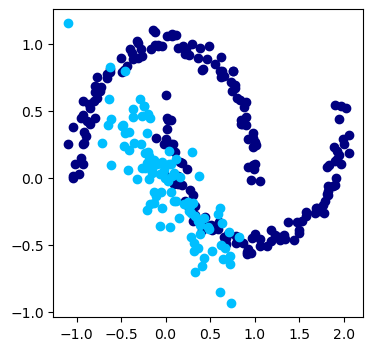

[51/200] 	Loss_D: -0.8108	Loss_G: -0.0535
[52/200] 	Loss_D: -0.8140	Loss_G: -0.0300
[53/200] 	Loss_D: -0.7792	Loss_G: -0.0300
[54/200] 	Loss_D: -0.7338	Loss_G: -0.0457
[55/200] 	Loss_D: -0.7954	Loss_G: -0.0276
[56/200] 	Loss_D: -0.7742	Loss_G: -0.0782
[57/200] 	Loss_D: -0.7867	Loss_G: -0.0205
[58/200] 	Loss_D: -0.8379	Loss_G: -0.0599
[59/200] 	Loss_D: -0.7814	Loss_G: -0.0597
[60/200] 	Loss_D: -0.7622	Loss_G: -0.0532
[61/200] 	Loss_D: -0.7884	Loss_G: -0.0390
[62/200] 	Loss_D: -0.7807	Loss_G: -0.0320
[63/200] 	Loss_D: -0.8091	Loss_G: -0.0513
[64/200] 	Loss_D: -0.8072	Loss_G: -0.0272
[65/200] 	Loss_D: -0.7819	Loss_G: -0.0359
[66/200] 	Loss_D: -0.7762	Loss_G: -0.0831
[67/200] 	Loss_D: -0.7936	Loss_G: -0.0883
[68/200] 	Loss_D: -0.8063	Loss_G: -0.0156
[69/200] 	Loss_D: -0.8058	Loss_G: -0.0899
[70/200] 	Loss_D: -0.7817	Loss_G: -0.0409
[71/200] 	Loss_D: -0.7879	Loss_G: -0.0355
[72/200] 	Loss_D: -0.7707	Loss_G: -0.0822
[73/200] 	Loss_D: -0.8005	Loss_G: -0.0780
[74/200] 	Loss_D: -0.8283	Loss_G: 

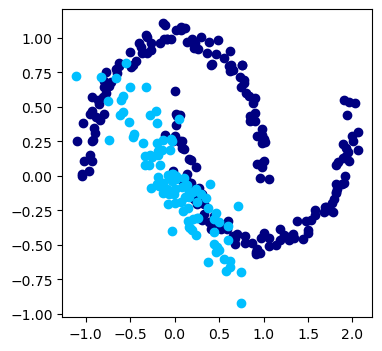

[101/200] 	Loss_D: -0.8035	Loss_G: -0.0385
[102/200] 	Loss_D: -0.8023	Loss_G: -0.0518
[103/200] 	Loss_D: -0.8096	Loss_G: -0.0867
[104/200] 	Loss_D: -0.8292	Loss_G: -0.0397
[105/200] 	Loss_D: -0.8058	Loss_G: -0.0493
[106/200] 	Loss_D: -0.8137	Loss_G: -0.0400
[107/200] 	Loss_D: -0.8238	Loss_G: -0.0702
[108/200] 	Loss_D: -0.7559	Loss_G: -0.0461
[109/200] 	Loss_D: -0.7668	Loss_G: -0.0934
[110/200] 	Loss_D: -0.8048	Loss_G: -0.0468
[111/200] 	Loss_D: -0.7787	Loss_G: -0.0665
[112/200] 	Loss_D: -0.7813	Loss_G: -0.0295
[113/200] 	Loss_D: -0.8194	Loss_G: -0.0600
[114/200] 	Loss_D: -0.7852	Loss_G: -0.0602
[115/200] 	Loss_D: -0.7878	Loss_G: -0.0501
[116/200] 	Loss_D: -0.7568	Loss_G: -0.0200
[117/200] 	Loss_D: -0.7896	Loss_G: -0.0743
[118/200] 	Loss_D: -0.7995	Loss_G: -0.0692
[119/200] 	Loss_D: -0.7833	Loss_G: -0.0399
[120/200] 	Loss_D: -0.7804	Loss_G: -0.0636
[121/200] 	Loss_D: -0.7874	Loss_G: -0.0200
[122/200] 	Loss_D: -0.7994	Loss_G: -0.0605
[123/200] 	Loss_D: -0.7305	Loss_G: -0.0000
[124/200] 	

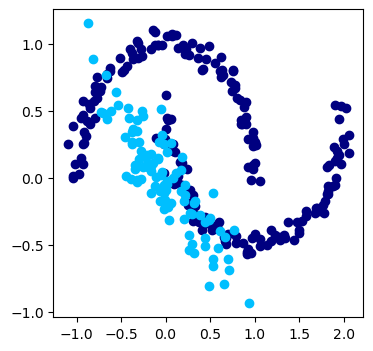

[151/200] 	Loss_D: -0.7782	Loss_G: -0.0365
[152/200] 	Loss_D: -0.7594	Loss_G: -0.0200
[153/200] 	Loss_D: -0.8102	Loss_G: -0.0477
[154/200] 	Loss_D: -0.7903	Loss_G: -0.0900
[155/200] 	Loss_D: -0.7994	Loss_G: -0.0301
[156/200] 	Loss_D: -0.7602	Loss_G: -0.0474
[157/200] 	Loss_D: -0.7573	Loss_G: -0.0401
[158/200] 	Loss_D: -0.8162	Loss_G: -0.0400
[159/200] 	Loss_D: -0.8087	Loss_G: -0.0494
[160/200] 	Loss_D: -0.8399	Loss_G: -0.0904
[161/200] 	Loss_D: -0.7775	Loss_G: -0.0348
[162/200] 	Loss_D: -0.7996	Loss_G: -0.0209
[163/200] 	Loss_D: -0.8170	Loss_G: -0.0198
[164/200] 	Loss_D: -0.7795	Loss_G: -0.0800
[165/200] 	Loss_D: -0.8144	Loss_G: -0.0300
[166/200] 	Loss_D: -0.7751	Loss_G: -0.0755
[167/200] 	Loss_D: -0.7898	Loss_G: -0.0827
[168/200] 	Loss_D: -0.8196	Loss_G: -0.0400
[169/200] 	Loss_D: -0.7688	Loss_G: -0.0520
[170/200] 	Loss_D: -0.7971	Loss_G: -0.0303
[171/200] 	Loss_D: -0.8130	Loss_G: -0.0692
[172/200] 	Loss_D: -0.7738	Loss_G: -0.0179
[173/200] 	Loss_D: -0.7996	Loss_G: -0.0481
[174/200] 	

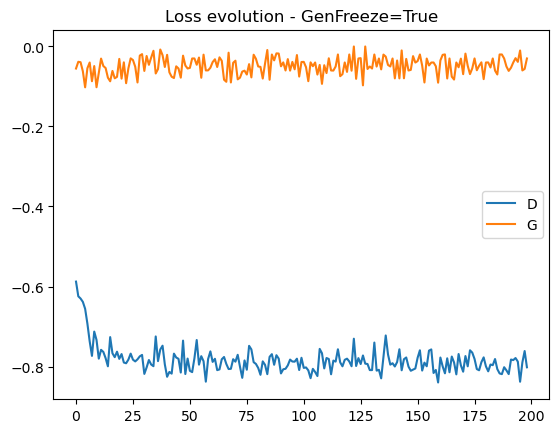

In [12]:
train_GAN(GenFreeze=True, lrdisc=1e-3, n_epochs=200, iter_display=50)

### Full training of D and G

We put 500 training iterations on D for 1 (one !) on G.
Still, training fails.

In [ ]:
train_GAN(GenFreeze=False, niterD=100, lrdisc=1e-3, n_epochs=100, iter_display=25)

### Q1.a Comment on the differences with respect to the WGAN learning algorithm.

The vanilla loss of GANs leads to try to optimise a JS divergence (in fact, two KL-divergences), between $p_{data}$ the probability distribution of the data in $\mathbb{R}^2$, and $p_{gen}(G(z))$ the probability distribution of $G(z)$ where $G$ is the generator and $z$ is drawn from a Gaussian. Issues arise when the supports of $p_{data}$ and  $p_{gen}(G(z))$ are disjoint, or worse, separated. Then the KLs go to infinity and the gradients vanish, making training unstable.

The WGAN loss is a Wasserstein loss, more precisely uses the dual formulation of the Wasserstein distance, based on Lipschitz functions. The Wasserstein distance has better conitnuity and differentiability properties than KL (euphemism) making training, theoretically, easier. However, the training algorithm needs to contain the gradient of the functions to keep them Lipschitz (ie by clipping or by regularization with gradient-penalty).

### Q1.b. Comment on the possible stability problems that you may encounter with the GAN algorithm.

As said above, the issue arises when the supports of $p_{data}$ and $p_{gen}(G(z))$ are disjoint, or worse, separated. The gradients vanish, we can get to a mode collapse, etc.

# WGAN Training

Evolution of the code

- added kwargs clip (Boolean) and grad_penalty (Boolean) to choose Lipschitz enforcement
- coded (and added printing) D gradient norm estimation

In [ ]:
def train_WGAN(
  GenFreeze=False,
  niterD=100,
  niterG=1,
  lrdisc=1e-2,
  lrgen=1e-3,
  iter_display=10,
  n_epochs=50,
  lambd = 1.0, # regul coeff for gradient penalty
  clip_value = 0.05,
  clip=False,
  grad_penalty=False
  ):
  """WGAN Training - same as GAN, but added regularization
  """
  
  # Report out
  print(f"Training WGAN - GenFreeze={GenFreeze}")
  
  if clip is False and grad_penalty is False:
    print(f"No regularization")
  elif clip is True:
    print(f"Clipping gradient with clip_value = {clip_value}")
  else:
    print(f"Gradient penalty with lambda = {lambd}")
  
  # Training loop

  # parameters
  lrgen = lrgen   # learning rate for generator
  lrdisc = lrdisc  # learning rate for discriminator
  n_epochs = n_epochs
  niterD=niterD
  niterG=niterG
  lambd=lambd
  clip_value=clip_value

  # Initialize generator and discriminator
  G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)
  D = DiscriminatorGAN(n_in=d, n_hid=100, device=device)

  # get ready
  optimG = optim.Adam(G.parameters(), lr=lrgen)
  optimD = optim.Adam(D.parameters(), lr=lrdisc) #, betas=(beta_1, beta_2))

  # logs
  Glosses = []
  Dlosses = []
  Gradient_norms = []

  # reporting 
  iter_display = iter_display
  
  # misc
  n_data = X_data.shape[0]

  # Main loop
  for epoch in range(1,n_epochs):

      ###########################################
      ### Train discriminator (niterD iterations)
      ###########################################
      
      #### ie max sur D de la loss
      for iter in range(0,niterD):
        g_norm_ests = []
        optimD.zero_grad()
        X_gen = G(torch.randn(b, n_in, device=device))
        Dx = D(X_gen)
        # we want to maximize D(X_data) and minimize D(X_gen)
        # Dloss should be as small as possible
        Dloss = - (torch.mean(D(X_data)) - torch.mean(Dx))
        
        if grad_penalty is True and clip is False:
          # Estimate Gradient of Discriminator
          
          # Sample points from the generator
          z = torch.randn(n_data, n_in, device=device)
          x = G(z) # shape : N x 2
          # Calculate interpolation between data and generated points
          alpha = torch.rand((n_data,1),device=device) # N x 1
          interp = (alpha * n_data + (1-alpha) * x) # .flatten(end_dim=1) # N x 2
          interp.requires_grad_()
          
          D_interp = D(interp) # N x 1
          gradout = torch.ones(D_interp.size()).to(device) # N x 1
          # autograd will actually compute a Gradient tensor N x 2, as output is N x scalar and input is N x 2
          gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 2
          
          est_gradient_norm = torch.mean(torch.sqrt((torch.sum(gradients**2,dim=1)))) # N x 1
          
          # print(f"Gradient norm estimate : {est_gradient_norm}")
          
          g_norm_ests.append(est_gradient_norm.item())
          # # calculate the loss with gradient penalty
          Dloss += lambd * (est_gradient_norm - 1)**2
        
        # clipping gradients if required
        if clip is True and grad_penalty is False:
          for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        # optimize
        optimD.zero_grad()
        Dloss.backward()
        optimD.step()

      if grad_penalty is True and clip is False:
        Gradient_norms.append(np.average(g_norm_ests))

      #######################################
      ### Train generator (niterG iterations)
      #######################################
      ### ie min sur G de la loss
      for iter in range(0,niterG):
        # we want to maximize D(G(z))
        # Gloss should be as small as possible
        Gloss = - torch.mean(D(G(torch.randn(b, n_in, device=device))))
        if GenFreeze is not True:
          optimG.zero_grad()
          Gloss.backward()
          optimG.step()

      # Output training stats
      if grad_penalty is False:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item()))
      else:
        print('[%d/%d] \tLoss_D: %.4f \tLoss_G: %.4f \tGradient_norm_est: %.4f'
          % (epoch, n_epochs, Dloss.item(), Gloss.item(), np.average(g_norm_ests)))
      Glosses.append(Gloss.item())
      Dlosses.append(Dloss.item())

      # draw pictures from time to time
      if(epoch % iter_display == 0):
          fig, ax = plt.subplots(figsize=(4, 4))
          # plot data
          ax.scatter(X_data.cpu()[:,0], X_data.cpu()[:,1], c='navy')
          # plot generated points
          z = torch.randn(b, n_in, device=device)
          x_gen = G(z).detach().cpu().numpy()
          ax.scatter(x_gen[:,0], x_gen[:,1], c='deepskyblue')
          plt.show()

  ### Plot the evolution of the discriminator and generator losses ###
  plt.figure(dpi=100)
  plt.plot(Dlosses,label='D')
  plt.plot(Glosses,label='G')
  # plt.plot(Gradient_norms, label='Gradient Norm Discriminator')
  plt.title(f'Loss evolution - GenFreeze={GenFreeze}')
  plt.legend()
  plt.show()

### WGAN-WC

Testing weight clipping

In [ ]:
# First, training Discriminator with Generator frozen
train_WGAN(GenFreeze=True, lrdisc=1e-3, niterD=100, clip=True, clip_value=10.0, iter_display=10)

In [ ]:
# Then, training both Discriminator and Generator
train_WGAN(GenFreeze=False, niterD=50, lrdisc=1e-3, iter_display=10, clip=True, n_epochs=100, clip_value=0.5)

Hum. Training failed with that set of parameters.

### WGAN-GP

In [ ]:
# First, training Discriminator with Generator frozen
train_WGAN(GenFreeze=True, lrdisc=1e-4, niterD=100, grad_penalty=True, n_epochs=50, lambd=1.0, iter_display=20)

In [ ]:
# Then, trying to train both Discriminator and Generator.
train_WGAN(GenFreeze=False, lrdisc=1e-4, niterD=100, lrgen=1e-4, grad_penalty=True, lambd=10.0, n_epochs=50, iter_display=20)

Still very difficult to train anything

### VAE

We code here a very simple VAE. 

The Encoder is going to encode from $\mathbb{R}^2$ into $\mathbb{R}^d$ (ie dim-d latent space), and decoder from $\mathbb{R}^d$ to $\mathbb{R}^2$.

The loss is the usual ELBO with a closed-form expression of the KL.

In [24]:
class ToyVAE(nn.Module):
    
    def __init__(self, n_neurons=16, latent_dim=2): #, scale=1.0):
        super(ToyVAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(2, n_neurons) # input dim = 2
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc_mu = nn.Linear(n_neurons, latent_dim)
        self.fc_logvar = nn.Linear(n_neurons, latent_dim)
        
        # decoder part
        self.fc3 = nn.Linear(latent_dim, n_neurons)
        self.fc4 = nn.Linear(n_neurons, n_neurons)
        self.fc5 = nn.Linear(n_neurons, 2)
        
    def rsample(self, mean, std): #, scale=None):
        # mean : B x latent_dim
        # std : B x latent_dim
        # if scale is None:
        #     scale=self.scale
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def encode(self,x):
        x = F.relu(self.fc1(x)) # B x n_neurons
        x = F.relu(self.fc2(x)) # B x n_neurons
        mu_x = self.fc_mu(x) # B x latent_dim : mu's of the Gaussians
        logvar_x = self.fc_logvar(x) # B x latent_dim : covariance matrix (assumed diagonal) of the Gaussians
        return mu_x, logvar_x
    
    def decode(self,z):
        z = F.relu(self.fc3(z)) # B x n_neurons
        z = F.relu(self.fc4(z)) # B x n_neurons
        x_hat = self.fc5(z) # B x 2
        return x_hat
    
    def forward(self,x):
        mu_x, logvar_x = self.encode(x)
        std_x = torch.exp(0.5 * logvar_x)
        z = self.rsample(mu_x, std_x)
        x_hat = self.decode(z)
        
        return x_hat, mu_x, logvar_x

In [25]:
def vae_loss(x, x_hat, mean, logvar):
    
    reconstruction_loss = torch.mean(torch.sum( (x-x_hat)**2, axis=1 ))
    kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())
    
    return reconstruction_loss + kl_loss, kl_loss, reconstruction_loss

### VAE Training loop

In [30]:
X_data = X_data.to(device)

def train_VAE(
    X_data = X_data,
    n_epochs = 10,
    optimizer = None,
    model = None,
):
    
    print(f"Start training {n_epochs} epochs")
    rec_losses = []
    kl_losses = []
    losses = []
    
    # model.train()
    
    for epoch in range(n_epochs):
        # forward pass
        x_hat, mean, logvar = model(X_data)
        # backward pass
        optimizer.zero_grad()
        # print(x_hat)
        loss, kl_loss, rec_loss = vae_loss(X_data, x_hat, mean, logvar)
        loss.backward()
        optimizer.step()
        # reporting out
        losses.append(loss.item())
        kl_losses.append(kl_loss.item())
        rec_losses.append(rec_loss.item())
        print(f"Epoch {epoch+1} / {n_epochs} -- loss = {loss.item():.4f} -- rec_loss = {rec_loss.item():.4f} -- kl_loss = {kl_loss.item():.4f}") #, end="\r")
        
    return losses, rec_losses, kl_losses  

Training Toy VAE

In [31]:
LATENT_DIM = 8

tvae = ToyVAE(latent_dim=LATENT_DIM).to(device)
optimizer = torch.optim.Adam(tvae.parameters())

Start training 1000 epochs
Epoch 1 / 1000 -- loss = 30.3532 -- rec_loss = 1.2887 -- kl_loss = 29.0645
Epoch 2 / 1000 -- loss = 29.1720 -- rec_loss = 1.2746 -- kl_loss = 27.8975
Epoch 3 / 1000 -- loss = 28.0342 -- rec_loss = 1.2646 -- kl_loss = 26.7697
Epoch 4 / 1000 -- loss = 26.9766 -- rec_loss = 1.2959 -- kl_loss = 25.6807
Epoch 5 / 1000 -- loss = 25.8855 -- rec_loss = 1.2564 -- kl_loss = 24.6291
Epoch 6 / 1000 -- loss = 24.8648 -- rec_loss = 1.2490 -- kl_loss = 23.6158
Epoch 7 / 1000 -- loss = 23.8732 -- rec_loss = 1.2326 -- kl_loss = 22.6407
Epoch 8 / 1000 -- loss = 22.9138 -- rec_loss = 1.2113 -- kl_loss = 21.7025
Epoch 9 / 1000 -- loss = 22.0018 -- rec_loss = 1.2010 -- kl_loss = 20.8008
Epoch 10 / 1000 -- loss = 21.1673 -- rec_loss = 1.2314 -- kl_loss = 19.9359
Epoch 11 / 1000 -- loss = 20.3361 -- rec_loss = 1.2307 -- kl_loss = 19.1054
Epoch 12 / 1000 -- loss = 19.4962 -- rec_loss = 1.1859 -- kl_loss = 18.3103
Epoch 13 / 1000 -- loss = 18.7168 -- rec_loss = 1.1659 -- kl_loss = 17

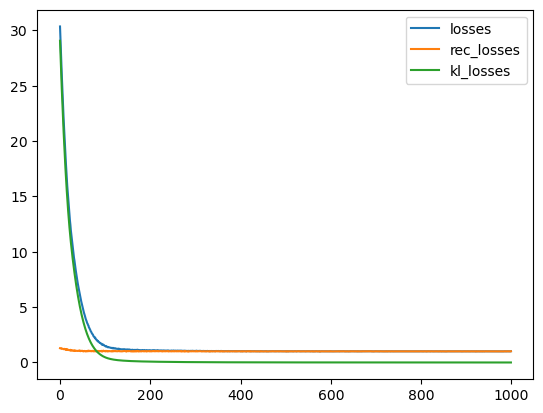

In [ ]:
losses, rec_losses, kl_losses = train_VAE(X_data, optimizer=optimizer, model=tvae, n_epochs=100)

plt.plot(losses, label='losses')
plt.plot(rec_losses, label='rec_losses')
plt.plot(kl_losses, label='kl_losses')
plt.legend()
plt.show()

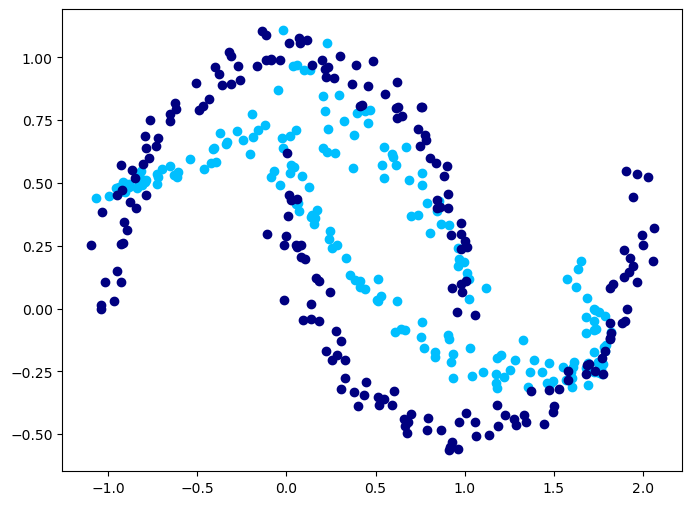

In [33]:
vae.eval()

with torch.no_grad():
    X_hat_data, mu, log_var = vae(X_data)
    
display(X_data.cpu(), X_hat_data.cpu())

### Q2.a

- GANs are difficult to train by definition of their loss function, composed of KL divergences. See above.
- WGANs bring some improvement, but the Lipschitz constraint on the discriminator is difficult to enforce. When using weigh_clipping, the clip value is hard to tune. When using gradient penalty, the weight on the gradient penalty is hard to turn.
- VAE proved surprinsigly difficult to tune, even on the two-moons toy case. If the weight on the KL-loss is too strong, then the algorithm will collapse the outputs to 0, as this actually minimizes the KL-divergence of the latent variable. This is probably due to the fact that the original data lies in $\mathbb{R}^2$, and it makes little sense to encode into a higher dimension latent space.

### Q2.b

- It is clear from the drawings that the generators of the GANs and WGANs are not doing a good job at covering the data distribution. This was clear as the training of the models was not satisfactory.
- In the case of the VAE, the plot shows a much better coverage. However, this is not truly satisfactory, as we are using a latent space of higher dimension that the data space.

# MNIST

### Dataloader, etc.

In [34]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data
from torch.utils.data import Subset

import os

In [35]:
print(os.getcwd())

/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/notebooks


In [36]:
batch_size=128 # can go to 4096+ for RTX 3080
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

datapath = '/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/data'  # setup IRT
# datapath = '/home/benjamin/Folders_Python/TP_GenAI_MVA_2025_02_25/data'  # setup CPU local
train_set = MNIST(datapath, train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [37]:
# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
      img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    plt.imshow(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

torch.Size([128, 1, 28, 28])


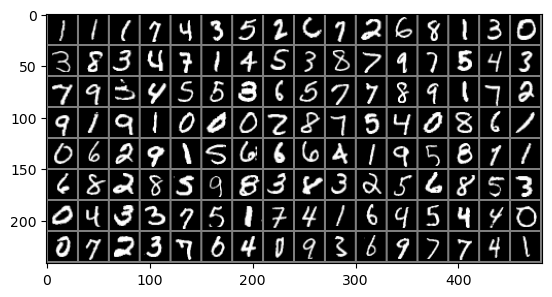

In [38]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

### WGAN

In [ ]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )
        self.prob = nn.Sigmoid()

    def forward(self, input):
        return self.prob(self.main(input).view(-1, 1).squeeze(1))

# Create some generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

### Display samples of the Generator

In [ ]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
      # print(f"z = {z.size()}")
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

# Load a pre-learned generator to see what you will get at the end of the practical session!:
G = Generator().to(device)
# G.load_state_dict(torch.hub.load_state_dict_from_url('https://perso.telecom-paristech.fr/aleclaire/mva/tp/wgan_epoch100.pt', progress=False))

# Display samples
show(G)

### Weigths Initialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G)

### Specific Training loop - WGAN with Gradient Penalty for MNIST

In [ ]:
# small dataloader to test the pipeline

# N_SMALL = 500
# subset_indices = range(N_SMALL)
# subset = Subset(train_set, subset_indices)

# sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [ ]:
def est_gradient_norm(n_samples=10):
    # Estimate Gradient of Discriminator on n_samples points
            
    # Sample points from the generator
    z = torch.randn(n_samples,nz,1,1).to(device)
    x_fake_sampled = G(z) # shape : N x 1 x 28 x 28
    # print(f"x_real = {x_real.size()}")
    # print(f"x_fake_sampled = {x_fake_sampled.size()}")
            
    # # Calculate interpolation between data and generated points
    alpha = torch.rand((n_samples,1,1,1),device=device) # N x 1 x 1 x 1
    # print(f"alpha = {alpha.size()}")
    # print(f"exemple alpha = {alpha[0]}")
    interp = (alpha * x_fake_sampled + (1-alpha) * x_real[:n_samples,:,:,:]) # N x 1 x 28 x 28
    # print(f"interp = {interp.size()}")
    interp.requires_grad_()
            
    D_interp = D(interp) # N x 1
    # print(f"D_interp = {D_interp.size()}")
    gradout = torch.ones(D_interp.size()).to(device) # N x 1
    # print(f"gradouts = {gradout.size()}") # N x 1
    # autograd will actually compute a Gradient tensor N x 1 x 28 x 28, 
    # as output is D_interp shape B
    # and input is interp shape N x 1 x 28 x 28
    # ----
    # gradients is shape N x 1 x 28 x 28
    gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0] # N x 1 x 28 x 28
    # print(f"gradients = {gradients.size()}")
    # -----
    # compute gradient norm estimate
    norms_squared = torch.sqrt(torch.sum(gradients**2,(2,3))) # B x 1 
    # print(f"norms_squared = {norms_squared.size()}")
    est_gradient_norm = torch.mean(norms_squared) #  1
    # print(est_gradient_norm)
    
    return est_gradient_norm

# est_gradient_norm()

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 2
log_every = 100
gpw = 5

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);
optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

niterD = 10

### The training below works -I trained a WGAN with GP and saved the model as 'Deporte_wgan.pt'- but took NINE HOURS on a RTX 3080.

I suspect the implemenatation of the gradient norm estimate is far from optimal.

In [ ]:
t0 = time.time()
list_gradient_norms = []
Dlosses = []
Dlosses_wogp = []
Glosses = []
Gradient_norms = []

for epoch in range(num_epochs):
    # For each batch in the train_loader
    losses_d_batch = []
    losses_d_wogp_batch = []
    losses_g_batch = []
    gradient_norms_batch = []
    
    for i, batch in enumerate(train_loader, 0):
         
        # losses_batch = []
        # gradient_norm_batch = []

        ############################
        # Draw Batches 
        ############################
        
        x_real = batch[0].to(device)  # B x 1 x 28 x 28
        # print(f"x_real = {x_real.size()}")
        
        x_fake = G(torch.randn(batch_size,nz,1,1).to(device)) # B x 1 x 28 x 28
        # print(f"x_fake = {x_fake.size()}")
        
        ################################
        # Train Discriminator 
        ################################
        
        for j in range(niterD):
            # print(f"Discriminator training {j+1} / {niterD}", end="\r")
            
            optimD.zero_grad()
            # Dloss sans gradient penalty : best is -1, worst is 1
            # loss sans la régul gradient penalty
            Dloss_wogp = - (torch.mean(D(x_real)) - torch.mean(D(x_fake)))
            
            gradient_norm = est_gradient_norm()
            
            # calculate the loss with gradient penalty
            Dloss = Dloss_wogp + gpw * (gradient_norm - 1)**2
                        
            # optimize
            optimD.zero_grad()
            Dloss.backward(retain_graph=True)
            optimD.step()
          
        # iteration losses log
        losses_d_wogp_batch.append(Dloss_wogp.item())
        losses_d_batch.append(Dloss.item())
        gradient_norms_batch.append(gradient_norm.item())
    
        ############################
        # Update G network
        ############################
        
        # Gloss : best is -1, worst is 0
        Gloss = - torch.mean(D(G(torch.randn(batch_size,nz,1,1).to(device))))
        optimG.zero_grad()
        Gloss.backward()
        optimG.step()
        
        losses_g_batch.append(Gloss.item())
        
        # reporting
        print(f"batch {i+1} / {len(train_loader)} \
            -- avg D loss sans GP = {np.average(losses_d_wogp_batch):.4f} \
            -- avg G loss = {np.average(losses_g_batch):.4f} \
            -- Gradient norm estimate : {gradient_norm:.4f}", \
            end="\r")
        
        ##############################
        ## Log 
        ##############################
        
    loss_d_wogp_epoch = np.average(losses_d_wogp_batch)
    loss_d_epoch = np.average(losses_d_batch)
    loss_g_epoch = np.average(losses_g_batch)
    gradient_norm_epoch = np.average(gradient_norms_batch)
    
    Dlosses_wogp.append(loss_d_wogp_epoch)
    Dlosses.append(loss_d_epoch)
    Glosses.append(loss_g_epoch)
    Gradient_norms.append(gradient_norm_epoch)
       
    print(f"epoch : {epoch+1} / {num_epochs} \
        --- loss D sans GP = {loss_d_wogp_epoch:.4f} \
        --- loss G = {loss_g_epoch:.4f} \
        --- gradient norm = {gradient_norm_epoch:.4f} \
                                                                ")
    

with torch.no_grad():
    z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))

tlt = time.time()-t0
print(f'Total learning time = {tlt:.4f}')

# # Save final generator in a variable for later use
# wgan = Generator()
# wgan.load_state_dict(G.state_dict())

# # Save final generator in a file
# torch.save(G.state_dict(), 'wgan.pt')

In [ ]:
plt.plot(Dlosses_wogp, label="D loss sans GP")
plt.plot(Glosses, label='G loss')
plt.legend()

plt.show()

# VAE - MLP encoder/decoder with L2 reconstruction loss

In [71]:
latent_dim = 2
hidden_dim = 288

In [79]:
class MnistVAE(nn.Module):
    
    def __init__(self, n_neurons=512, latent_dim=2): #, scale=1.0):
        super(MnistVAE, self).__init__()
        
        # encoder
        self.fc1 = nn.Linear(1*28*28, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc3 = nn.Linear(n_neurons, n_neurons)
        self.fc_mu = nn.Linear(n_neurons, latent_dim)
        self.fc_logvar = nn.Linear(n_neurons, latent_dim)
        
        # decoder
        self.fc4 = nn.Linear(latent_dim, n_neurons)
        self.fc5 = nn.Linear(n_neurons, n_neurons)
        self.fc6 = nn.Linear(n_neurons, 1*28*28)
        
    def rsample(self, mean, std): #, scale=None):
        # mean : B x latent_dim
        # std : B x latent_dim
        # if scale is None:
        #     scale=self.scale
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def encode(self,x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x)) # B x n_neurons
        x = F.relu(self.fc2(x)) # B x n_neurons
        mu_x = self.fc_mu(x) # B x latent_dim : mu's of the Gaussians
        logvar_x = self.fc_logvar(x) # B x latent_dim : covariance matrix (assumed diagonal) of the Gaussians
        return mu_x, logvar_x
    
    def decode(self,z):
        z = F.relu(self.fc4(z)) # B x n_neurons
        z = F.relu(self.fc5(z)) # B x n_neurons
        x_hat = self.fc6(z) # B x 2
        x_hat = x_hat.view(x_hat.size()[0],1,28,28)
        return x_hat
    
    def forward(self,x):
        mu_x, logvar_x = self.encode(x)
        std_x = torch.exp(0.5 * logvar_x)
        z = self.rsample(mu_x, std_x)
        x_hat = self.decode(z)
        
        return x_hat, mu_x, logvar_x

In [80]:
# check dimensions
mvae = MnistVAE(latent_dim=latent_dim)

x = torch.randn(128, 1, 28, 28) # B (batch size) x 1 x 28 x 28

print(f"input shape = {x.shape}")

x_hat, mu, logvar = mvae(x)

print(f"outputs shapes : x_hat = {x_hat.size()}, mus = {mu.size()},  logvars = {logvar.size()}")

input shape = torch.Size([128, 1, 28, 28])
outputs shapes : x_hat = torch.Size([128, 1, 28, 28]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])


In [ ]:
def mnist_vae_loss(x, x_hat, mean, logvar):
    
    reconstruction_loss = torch.mean(torch.sum( (x-x_hat)**2, axis=[1,2,3] ))
    kl_loss = - 0.5 * torch.sum( 1 + logvar - mean**2 - logvar.exp())
    
    return reconstruction_loss + kl_loss, kl_loss, reconstruction_loss

# l = mnist_vae_loss(x, x_hat, mu, logvar)
# print(f"Total loss = {l}")

### MNIST VAE Training Loop

In [83]:
def train_MNIST_VAE(
    loader = None,
    n_epochs = 10,
    optimizer = None,
    model = None,
):
    """_summary_

    Args:
        loader (_type_, optional): sample_loader ou train_loader. Defaults to None.
        n_epochs (int, optional): _description_. Defaults to 10.
        optimizer (_type_, optional): _# Decoder to sample back from vector latent_dim to 28 x 28

    Returns:
        _type_: lists of losses
    """
    
    print(f"Start training {n_epochs} epochs on MNIST VAE")
    rec_losses = []
    kl_losses = []
    total_losses = []
    
    # model.train()
    
    for epoch in range(n_epochs):
        
        # init batch measurements
        batch_kl_losses = []
        batch_rec_losses = []
        batch_total_losses = []
        
        for i, batch in enumerate(loader, 0):
            
            # forward pass
            x = batch[0]
            x_hat, mean, logvar = model(x)
            
            # backward pass
            optimizer.zero_grad()
            # print(x_hat)
            total_loss, kl_loss, rec_loss = mnist_vae_loss(x, x_hat, mean, logvar)
            total_loss.backward()
            optimizer.step()
            
            # logging at batch level
            batch_kl_losses.append(kl_loss.item())
            batch_rec_losses.append(rec_loss.item())
            batch_total_losses.append(total_loss.item())
            
            # reporting out at batch level
            print(f"Batch {i+1} / {len(loader)} \
            -- total loss = {batch_total_losses[-1]:.4f} \
            -- reco loss = {batch_rec_losses[-1]:.4f} \
            -- KL loss = {batch_kl_losses[-1]:.4f}", \
            end="\r")
            
        # logging at epoch level
        total_losses.append(np.average(batch_total_losses))  
        rec_losses.append(np.average(batch_rec_losses)) 
        kl_losses.append(np.average(batch_kl_losses)) 
        
        # reporting out at epoch level
        print(f"Epoch {epoch+1} / {n_epochs} \
            -- loss = {total_losses[-1]:.4f} \
            -- rec_loss = {rec_losses[-1]:.4f} \
            -- kl_loss = {kl_losses[-1]:.4f} \
                                           "
        ) #, end="\r")
        
    return total_losses, rec_losses, kl_losses  

### Training VAE

In [84]:
# small dataloader to test the pipeline

# N_SMALL = 1000
# subset_indices = range(N_SMALL)
# subset = Subset(train_set, subset_indices)

# sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

In [85]:
latent_dim = 2
mnist_vae = MnistVAE(latent_dim=latent_dim)
optimizer = torch.optim.Adam(mnist_vae.parameters())

In [87]:
n_epochs = 10
kl_weight = 0.5

total_losses, rec_losses, kl_losses = train_MNIST_VAE(
    loader=train_loader, 
    n_epochs=n_epochs, 
    optimizer=optimizer, 
    model=mnist_vae,
    )

Start training 10 epochs on MNIST VAE
Epoch 1 / 10             -- loss = 217.6515             -- rec_loss = 217.0811             -- kl_loss = 0.5704                                            
Epoch 2 / 10             -- loss = 211.8414             -- rec_loss = 211.8379             -- kl_loss = 0.0035                                            
Epoch 3 / 10             -- loss = 211.7422             -- rec_loss = 211.7401             -- kl_loss = 0.0021                                            
Epoch 4 / 10             -- loss = 211.5778             -- rec_loss = 211.5767             -- kl_loss = 0.0011                                            
Epoch 5 / 10             -- loss = 211.5148             -- rec_loss = 211.5141             -- kl_loss = 0.0006                                            
Epoch 6 / 10             -- loss = 211.4459             -- rec_loss = 211.4454             -- kl_loss = 0.0005                                            
Epoch 7 / 10             -- loss

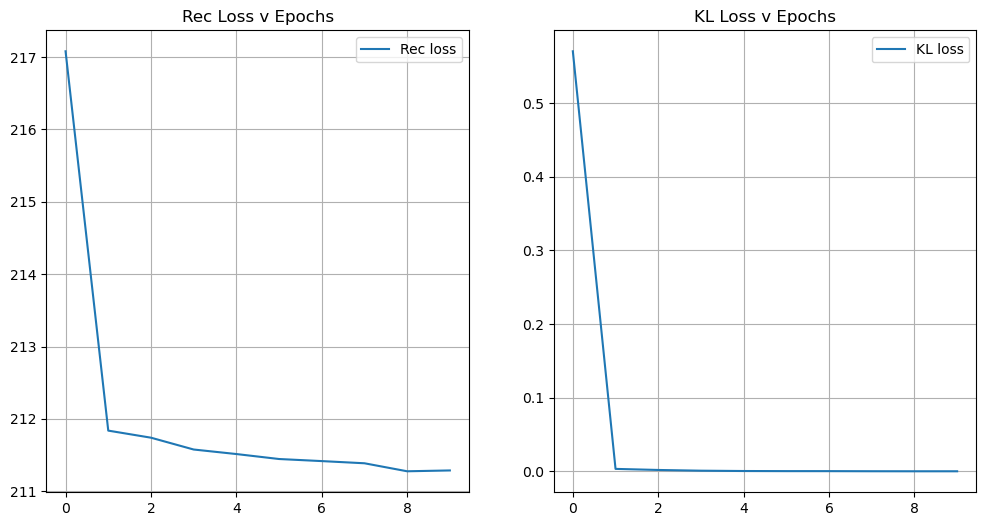

In [88]:
fig, axs = plt.subplots(figsize=(12,6), nrows=1, ncols=2)

axs[0].set_title(f"Rec Loss v Epochs")
axs[0].plot(rec_losses, label="Rec loss")
axs[0].legend()
axs[0].grid()

axs[1].set_title(f"KL Loss v Epochs")
axs[1].plot(kl_losses, label="KL loss")
axs[1].legend()
axs[1].grid()

### Sampling some images

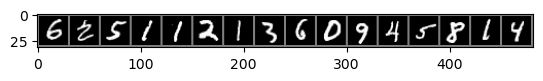

In [89]:
# get original images

N_SAMPLES = 16

real, label = next(iter(train_loader))

real = real[:N_SAMPLES]
pil_img = imshow(torchvision.utils.make_grid(real.to(device),nrow=16))

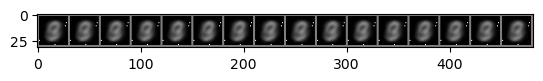

In [90]:
mus, logvars = mnist_vae.encode(real)
samples = mnist_vae.decode(mus)

pil_samples_img = imshow(torchvision.utils.make_grid(samples.to(device),nrow=16))

The network is not learning. I suspect the loss function (L2) being unappropriate.

# VAE MNIST : Changing pipeline to use Binary Cross Entropy as a loss instead of L2. 

BCE is expected to be more appropriate when dealing with pixels between 0 and 1.

In [91]:
# here, we normalize between 0 and 1
batch_size=128 # can go to 4096+ for RTX 3080

# file path, depends where we run
datapath = '/home/benjamin.deporte/MVA/TP_GenAI_MVA_2025_02_25/data'  # setup IRT
# datapath = '/home/benjamin/Folders_Python/TP_GenAI_MVA_2025_02_25/data'  # setup CPU local

# MNIST Dataset
train_dataset2 = MNIST(datapath, train=True, transform=transforms.ToTensor(), download=True)
test_dataset2 = MNIST(datapath, train=False, transform=transforms.ToTensor(), download=False)

# Data Loader for FULL dataset 
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset2, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# Small dataloader to test the pipeline
N_SMALL = 1000
subset_indices = range(N_SMALL)
subset = Subset(train_dataset2, subset_indices)

sample_loader = data.DataLoader(subset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

torch.Size([128, 1, 28, 28])
Min = 0.0
Max = 1.0


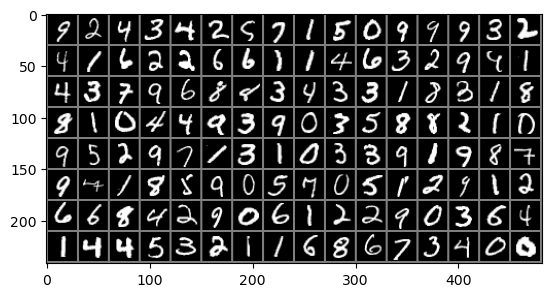

In [114]:
real,_ = next(iter(train_loader2))
print(real.shape)
print(f"Min = {real[0].min()}")
print(f"Max = {real[0].max()}")

real2 = real * 2 - 1
pil_img = imshow(torchvision.utils.make_grid(real2.to('cpu'),nrow=16))

### Starting simple : encoder and decoder are MLPs

NB : it would have been nicer to have the encoder and decoder as attributes of the overall VAE class.

However, for some reason, in that case the parameters of self.encoder and self.decoder do not flow into the optimizer, and training does not happen. Insight is welcome if you know the issue :-)

In [107]:
class MNIST_VAE_2(nn.Module):
    def __init__(self, n_neurons=512, latent_dim=2):
        super(MNIST_VAE_2, self).__init__()
        
        # encoder MLP
        self.fc1 = nn.Linear(784, n_neurons)
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.fc_mu = nn.Linear(n_neurons, latent_dim)
        self.fc_logvar = nn.Linear(n_neurons, latent_dim)
        # decoder MLP
        self.fc4 = nn.Linear(latent_dim, n_neurons)
        self.fc5 = nn.Linear(n_neurons, n_neurons)
        self.fc6 = nn.Linear(n_neurons, 784)
        
    def encoder(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc_mu(x), self.fc_logvar(x) # mu, log_var
    
    def rsample(self, mean, std):
        # mean : B x latent_dim
        # std : B x latent_dim
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
          
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu_x, logvar_x = self.encoder(x.view(-1, 784))
        z = self.rsample(mu_x, logvar_x)
        return self.decoder(z), mu_x, logvar_x

In [108]:
# check dimensions

mvae = MNIST_VAE_2(latent_dim=latent_dim)

x = torch.randn(128, 1, 28, 28) # B (batch size) x 1 x 28 x 28
print(f"input shape = {x.shape}")

x_hat, mu, logvar = mvae(x)
print(f"outputs shapes : x_hat = {x_hat.size()}, mus = {mu.size()},  logvars = {logvar.size()}")

# must be :
# input shape = torch.Size([128, 1, 28, 28])
# outputs shapes : x_hat = torch.Size([128, 784]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])

input shape = torch.Size([128, 1, 28, 28])
outputs shapes : x_hat = torch.Size([128, 784]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])


In [109]:
# loss function, returns all losses
# using BCE rather than L2 

def mnist_vae_bce_loss(x_hat, x, mean, logvar):
    reconstruction_loss = F.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    total_loss = reconstruction_loss + kl_loss
    
    return total_loss, kl_loss, reconstruction_loss

In [110]:
def train_MNIST_VAE_BCE(
    loader = None,
    n_epochs = 50,
    optimizer = None,
    model = None,
    kl_weight = 0.5,
    cnn = False
):
    """_summary_

    Args:
        loader (_type_, optional): sample_loader ou train_loader. Defaults to None.
        n_epochs (int, optional): _description_. Defaults to 50.
        optimizer (_type_, optional): 
        kl_weight : weight of the KL in the total loss, should not be changed. Default to 0.5
        cnn : True if passing a CNN model (inputs stay at B x 1 x 28 x 28, and are not recast into B x 784)
        
    Returns:
        _type_: lists of losses
    """
    
    print(f"Start training {n_epochs} epochs on MNIST VAE")
    rec_losses = []
    kl_losses = []
    total_losses = []
    
    model.train()
       
    for epoch in range(n_epochs):
        
        # init batch measurements
        batch_kl_losses = []
        batch_rec_losses = []
        batch_total_losses = []
        
        for i, batch in enumerate(loader, 0):
            
            # forward pass
            if cnn is True:
                x = batch[0]
            else:
                x = batch[0].view(-1,784)
            x_hat, mean, logvar = model(x)
            
            # backward pass
            optimizer.zero_grad()
            total_loss, kl_loss, rec_loss = mnist_vae_bce_loss(x_hat, x, mean, logvar)
            total_loss.backward()
            optimizer.step()
            
            # logging at batch level
            batch_kl_losses.append(kl_loss.item())
            batch_rec_losses.append(rec_loss.item())
            batch_total_losses.append(total_loss.item())
            
            # reporting out at batch level
            print(f"Batch {i+1} / {len(loader)} \
            -- total loss = {batch_total_losses[-1]:.4f} \
            -- reco loss = {batch_rec_losses[-1]:.4f} \
            -- KL loss = {batch_kl_losses[-1]:.4f}", \
            end="\r")
            
        # logging at epoch level
        total_losses.append(np.average(batch_total_losses))  
        rec_losses.append(np.average(batch_rec_losses)) 
        kl_losses.append(np.average(batch_kl_losses)) 
        
        # reporting out at epoch level
        print(f"Epoch {epoch+1} / {n_epochs} \
            -- loss = {total_losses[-1]:.4f} \
            -- rec_loss = {rec_losses[-1]:.4f} \
            -- kl_loss = {kl_losses[-1]:.4f} \
                                           ")
        
    return total_losses, rec_losses, kl_losses  

In [111]:
latent_dim = 2
mvae = MNIST_VAE_2(latent_dim=latent_dim)
optimizer_mvae = torch.optim.Adam(mvae.parameters())

In [112]:
n_epochs = 50

total_losses, rec_losses, kl_losses = train_MNIST_VAE_BCE(
    loader=train_loader2, 
    n_epochs=n_epochs, 
    optimizer=optimizer_mvae, 
    model=mvae,
    )

Start training 50 epochs on MNIST VAE
Epoch 1 / 50             -- loss = 22039.9607             -- rec_loss = 21910.1169             -- kl_loss = 129.8439                                            
Epoch 2 / 50             -- loss = 19166.2439             -- rec_loss = 19071.8494             -- kl_loss = 94.3945                                            
Epoch 3 / 50             -- loss = 18511.8626             -- rec_loss = 18424.4314             -- kl_loss = 87.4312                                            
Epoch 4 / 50             -- loss = 18117.1842             -- rec_loss = 18035.2116             -- kl_loss = 81.9726                                            
Epoch 5 / 50             -- loss = 17874.5658             -- rec_loss = 17796.3378             -- kl_loss = 78.2280                                            
Epoch 6 / 50             -- loss = 17691.4715             -- rec_loss = 17618.3731             -- kl_loss = 73.0985                                            
E

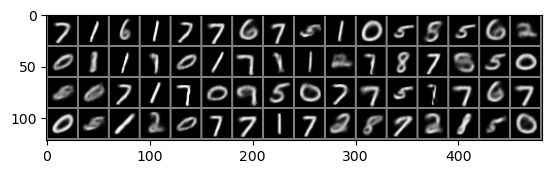

In [113]:
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    sample = mvae.decoder(z) * 2 - 1

s = sample.view(64,1,28,28)

pil_img = imshow(torchvision.utils.make_grid(s.to('cpu'),nrow=16))

### Much better with BCE !

### Next : encoder and decoder are Conv2D-based

In [100]:
class MNIST_VAE_CNN(nn.Module):
    
    def __init__(self, latent_dim=2): 
        super(MNIST_VAE_CNN, self).__init__()
        
        # hidden dim
        n = 32 * 3 * 3
        # encoder CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, padding=3)
        self.fc_mu = nn.Linear(n, latent_dim)
        self.fc_logvar = nn.Linear(n, latent_dim)
        
        # decoder CNN
        self.fc1 = nn.Linear(latent_dim, n)
        self.deconv1 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 1, kernel_size=7, stride=2, padding=1, output_padding=1)
        
    def rsample(self, mean, std):
        # mean : B x latent_dim
        # std : B x latent_dim
        epsilon = torch.randn_like(mean) # N(0,1) shape B x latent_dim 
        z = mean + std * epsilon # * scale # B x 1 \sim \mathcal{N}(mu, var)
        return z
    
    def encode(self, inputs):
        # encoder forward
        # inputs is B x 1 x 28 x 28
        x = self.conv1(inputs)
        x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 16 x 14 x 14
        x = self.conv2(x) # out : batch x 32 x 14 x 14
        x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 32 x 7 x 7
        x = self.conv3(x) # out : B x 32 x 7 x 7
        x = F.relu(nn.AvgPool2d(2)(x)) # out : B x 32 x 3 x 3
        x = x.view((x.size()[0], -1)) # out : B x 288
        mu_x = self.fc_mu(x) # out : B x latent_dim
        logvar_x = self.fc_logvar(x) # out : B x latent_dim
        return mu_x, logvar_x
    
    def decode(self, z):
        x = F.relu(self.fc1(z)) # out : B x (hidden_dim)
        x = x.reshape(x.shape[0], 32, 3, 3) # out B * 32 * 3 * 3
        x = self.deconv1(x) # out : B x 32 x 3 x 3
        x = self.deconv2(x) # out : B x 32 x 6 x 6
        x = self.deconv3(x) # out : B x 32 x 12 x 12
        x = self.deconv4(x) # out : B x 32 x 28 x 28
        x_hat = F.sigmoid(x).view(-1,784)
        return x_hat
    
    def forward(self,inputs):
        # encode
        mu_x, logvar_x = self.encode(inputs)

        # sample with reparametrisation trick
        std_x = torch.exp(0.5 * logvar_x)
        z = self.rsample(mu_x, std_x)
                
        # # decoder forward
        x_hat = self.decode(z)

        return x_hat, mu_x, logvar_x

In [101]:
# check dimensions
mvae = MNIST_VAE_CNN(latent_dim=latent_dim)

x = torch.randn(128, 1, 28, 28) # B (batch size) x 1 x 28 x 28

print(f"input shape = {x.shape}")

x_hat, mu, logvar = mvae(x)

print(f"outputs shapes : x_hat = {x_hat.size()}, mus = {mu.size()},  logvars = {logvar.size()}")

# print(x_hat.min())
# print(x_hat.max())

# MUST BE :
# input shape = torch.Size([128, 1, 28, 28])
# outputs shapes : x_hat = torch.Size([128, 784]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])

input shape = torch.Size([128, 1, 28, 28])
outputs shapes : x_hat = torch.Size([128, 784]), mus = torch.Size([128, 2]),  logvars = torch.Size([128, 2])


In [102]:
latent_dim = 2
mvae = MNIST_VAE_CNN(latent_dim=latent_dim)

# lr = 1e-4
optimizer_mvae = torch.optim.Adam(mvae.parameters()) #, lr=lr)

In [103]:
n_epochs = 50

total_losses, rec_losses, kl_losses = train_MNIST_VAE_BCE(
    loader=train_loader2, 
    n_epochs=n_epochs, 
    optimizer=optimizer_mvae, 
    model=mvae,
    cnn=True
    )

Start training 50 epochs on MNIST VAE
Epoch 1 / 50             -- loss = 26042.8976             # -- rec_loss = 25668.4171             # -- kl_loss = 374.4805                                            
Epoch 2 / 50             -- loss = 21785.4297             # -- rec_loss = 21222.4151             # -- kl_loss = 563.0146                                            
Epoch 3 / 50             -- loss = 21214.2975             # -- rec_loss = 20609.8901             # -- kl_loss = 604.4074                                            
Epoch 4 / 50             -- loss = 20868.5034             # -- rec_loss = 20235.1001             # -- kl_loss = 633.4033                                            
Epoch 5 / 50             -- loss = 20611.6242             # -- rec_loss = 19956.3009             # -- kl_loss = 655.3233                                            
Epoch 6 / 50             -- loss = 20421.4636             # -- rec_loss = 19751.7248             # -- kl_loss = 669.7388                 

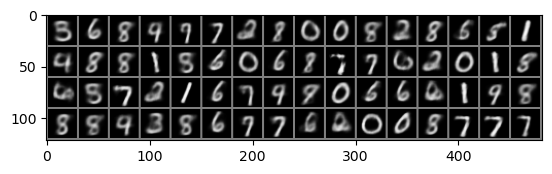

In [105]:
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    sample = mvae.decode(z) * 2 - 1

s = sample.view(64,1,28,28)

pil_img = imshow(torchvision.utils.make_grid(s.to('cpu'),nrow=16))

Not much better than MLPs but the latent dimension is low (2)

### Q3.a

I eventually managed to train a WGAN with GP -and saved model as "Deporte_wgan.pt". However, the estimation of the gradient of the Discriminator proved very demanding in terms of computing (maybe my implementation was not optimal ?) : it tool nine hours of training on a RTX 3080, which is not reasonnably for a toy case.

The VAEs proved much easier to train. I needed time to debug my code -the BCE loss was not properly coded, the training did not happen when the used the encoder and decoder as attributes self.encoder and self.decoder. Once this was done -after some long painful hours- the training took place without issue.

In both cases, the generated images are fair.

### Q3.b

Definitely VAE, which seem to require much less tuning than GANs.

GANs proved highly unstable, which is a direct consequence of the loss formulation with KLs. 
WGANs seem a good option, as long as the enforcement of the Lipschitz constraint is reasonnable, ie with a gradient penalty. 

# Q4

### Q4.a Frechet Inception Distance

The FID is basically the Wasserstein-2 distance. 

Between two probability distributions $\mu$ and $\nu$ over $\mathbb{R}^n$ with finite mean and variance, we have: $d_F (\mu, \nu) := \left( \underset{\gamma \in \Gamma(\mu,\nu)} {\text{inf}} \int_{\mathbb{R}^n \times \mathbb{R}^n} \vert\vert x-y \vert\vert^2 d\gamma(x,y) \right) ^{\frac{1}{2}}$

Which gives for two Gaussians $\mathcal{N}(\mu,\Sigma)$ and $\mathcal{N}(\mu',\Sigma')$ : 

$d_F (\mathcal{N}(\mu,\Sigma), \mathcal{N}(\mu',\Sigma')) = \vert\vert \mu - \mu' \vert\vert^2_2 + \text{tr} \left( \Sigma + \Sigma' - 2  (\Sigma \Sigma')^{\frac{1}{2}} \right)$

The idea is to take a dataset of "real" images $\mathcal{X}_d$ and a set of generated images $\mathcal{X}_g$, to fit them into two Gaussians, and to calculate the FID between the two Gaussians. (The Wassterstein-2 distance being harder to compute than the W-1)

The FID is computing a distance to the original dataset. One can imagine that this distance can be significantly large, if the support of the generated images happens to be larger than the support of the real images - typically when generated images are significantly different from real ones.

In other words, a generated image can be realistic and of high quality, but significantly different from the learnt dataset.

One adaptation is to run the generated and real images through the same model (for example VGG) and to compute distances between feature maps. This way, the "realism" of generated images is assessed, more than the actual distance to the ground truth dataset.

### Q4.b 

One way to do this is to train the generative model on $(x,c)$ where $x$ is the image, and $c$ the class it belongs to. The generator can then sample tuples $(\hat{x}, \hat{c}$), and one can compute the similarity between the distributions of $c$ and $\hat{c}$.

### Q4.c

One possible limitations of Q4.b lies where the distribution $c$ of the classes is irregular or unbalanced. Then the generation will be more difficult.